# Setup

**Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)

**Utility functions**

In [2]:
def fig_ax(figsize=(15, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.autoscale(enable=True, axis='x', tight=True)
    return fig, ax

# Spectral feature

## Question 6

In [3]:
def gamma_hat(X, N):
    gamma_hat = np.zeros(N)
    for tau in range(N):
        sum_gamma = 0
        for i in range(N - tau):
            sum_gamma += X[i] * X[i + tau]
        gamma_hat[tau] = sum_gamma / (N)
    return gamma_hat

def periodogram(X, N, f_s):
    freqs = np.linspace(0, 0.5, N)
    discret_ft = np.zeros(N, dtype=complex)
    gamma_hat_values = gamma_hat(X, N)

    for i, f in enumerate(freqs):
        sum_ft = 0
        for tau in range(N):
            sum_ft += gamma_hat_values[tau] * np.exp(-2j * np.pi * f * tau/f_s)
        discret_ft[i] = sum_ft
    
    return discret_ft

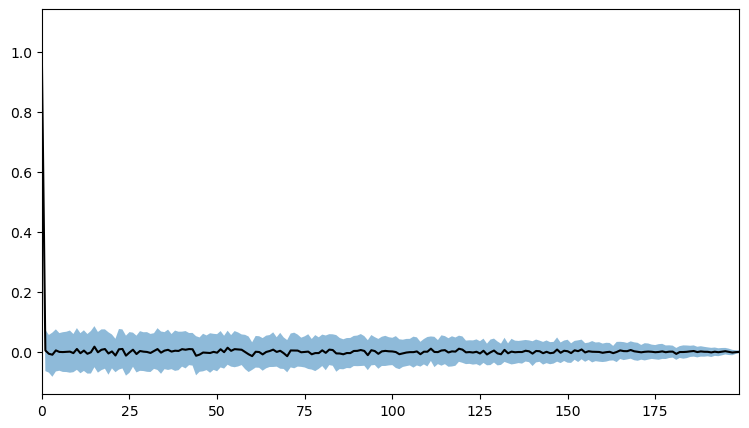

/home/lorenzo/miniconda3/envs/tutorial-mva-1/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/lorenzo/miniconda3/envs/tutorial-mva-1/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/lorenzo/miniconda3/envs/tutorial-mva-1/lib/python3.12/site-packages/matplotlib/axes/_axes.py:5616: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[0] = start
/home/lorenzo/miniconda3/envs/tutorial-mva-1/lib/python3.12/site-packages/matplotlib/axes/_axes.py:5617: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[N + 1] = end
/home/lorenzo/miniconda3/envs/tutorial-mva-1/lib/python3.12/site-packages/matplotlib/axes/_axes.py:5620: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[1:N+1, 1] 

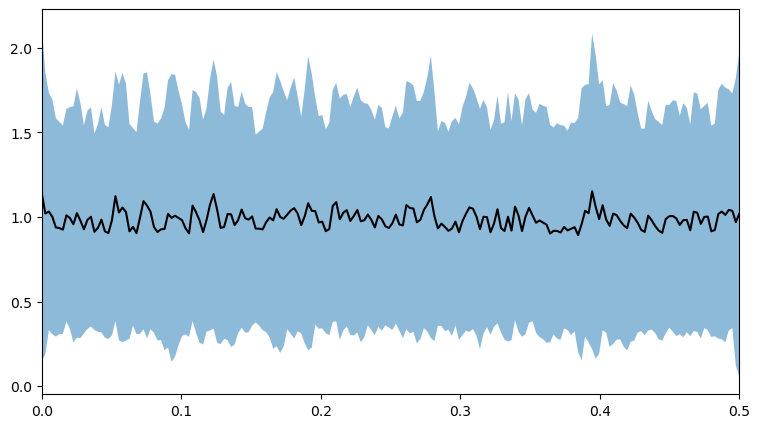

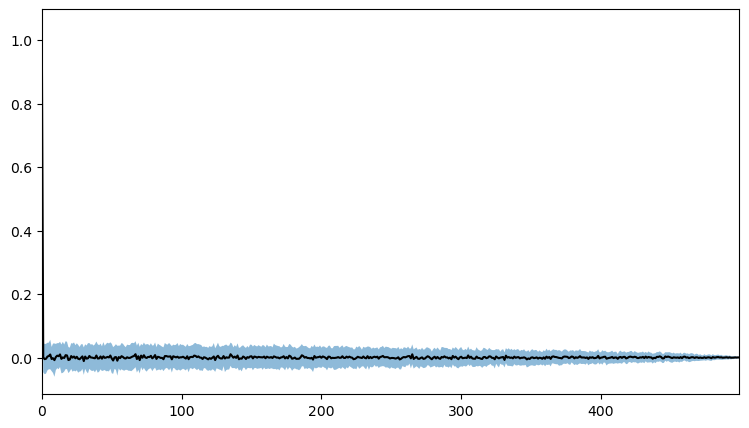

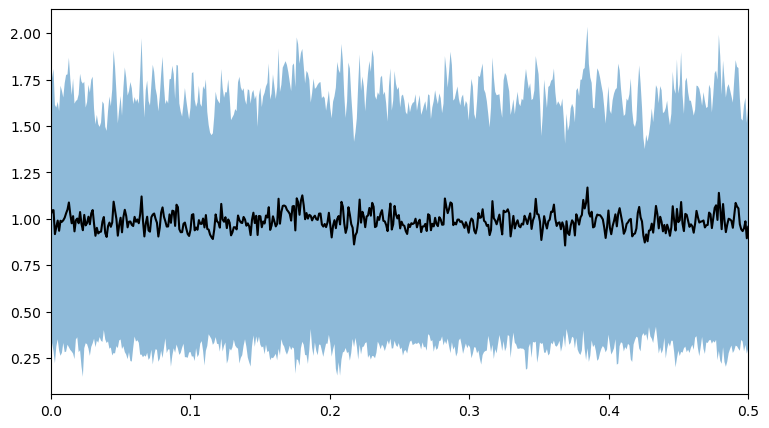

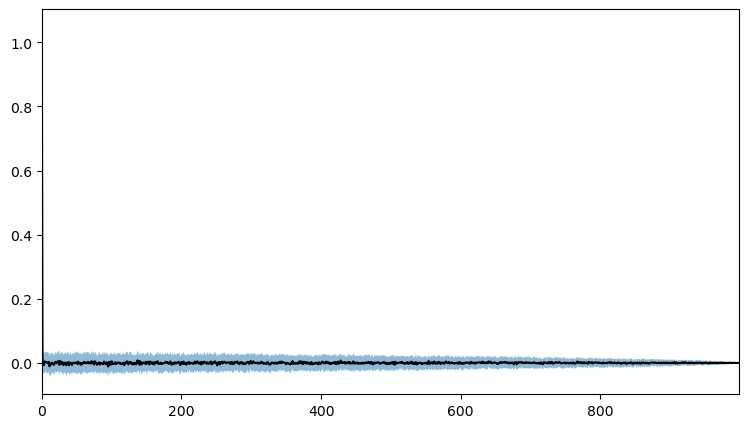

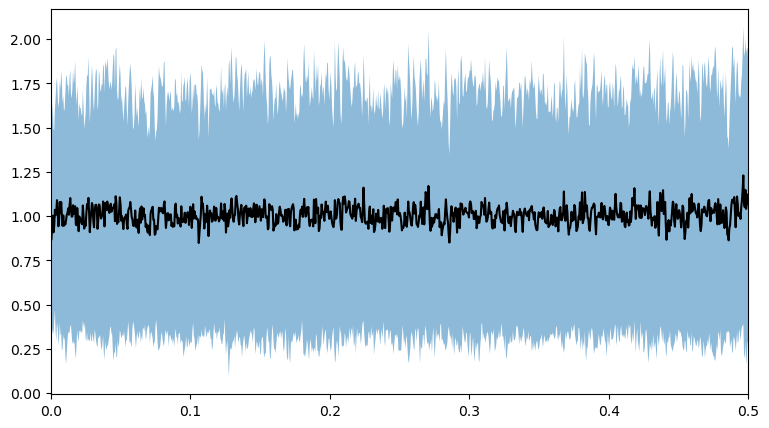

In [4]:
# This is an example of plot (random data). You can change it if you want.

for N in [200, 500, 1000]:
    all_gamma_hats = np.zeros((100, N))
    all_periodograms = np.zeros((100, N), dtype=complex)
    for i in range(100):

        X = np.random.randn(N) # Generate random data
        gamma_vals = gamma_hat(X, N) # Compute the sample autocorrelation function
        periodogram_vals = periodogram(X, N, f_s=1)

        # Store the result
        all_gamma_hats[i, :] = gamma_vals
        all_periodograms[i, :] = periodogram_vals

    # Compute mean and standard deviation across simulations
    mean_gamma_hat = np.mean(all_gamma_hats, axis=0)
    std_gamma_hat = np.std(all_gamma_hats, axis=0)

    mean_periodogram = np.mean(all_periodograms, axis=0)
    std_periodogram = np.std(all_periodograms, axis=0)

    tau = np.arange(N)
    fig, ax = fig_ax(figsize=(9, 5))
    ax.plot(tau, mean_gamma_hat, 'k-')
    ax.fill_between(tau, mean_gamma_hat-std_gamma_hat, mean_gamma_hat+std_gamma_hat, alpha=0.5)
    plt.show()

    freqs = np.linspace(0, 0.5, N)
    fig, ax = fig_ax(figsize=(9, 5))
    ax.plot(freqs, mean_periodogram, 'k-')
    ax.fill_between(freqs, mean_periodogram-std_periodogram, mean_periodogram+std_periodogram, alpha=0.5)
    plt.show()


## Question 9

In [5]:
def bartlett_periodogram(X, N, K, f_s):
    L = N // K  # Length of each section
    avg_periodogram = np.zeros(N, dtype=complex)

    for j in range(K):
        section = X[j * L:(j + 1) * L]  # Get the j-th section
        periodogram_vals = periodogram(section, L, f_s)
        avg_periodogram[j * L:(j + 1) * L] += periodogram_vals

    return avg_periodogram / K

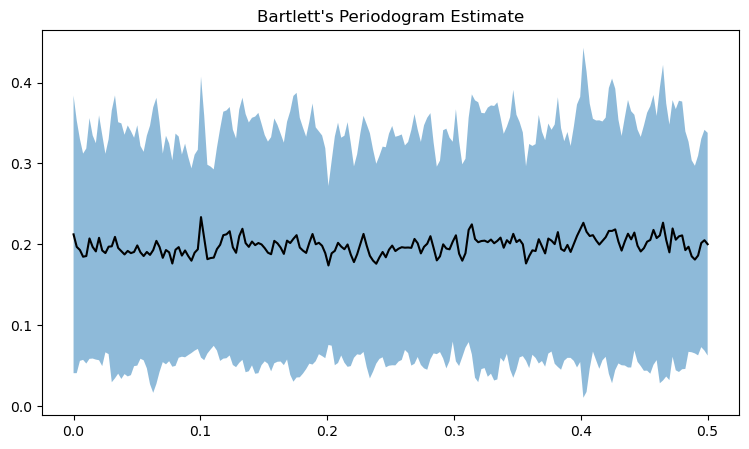

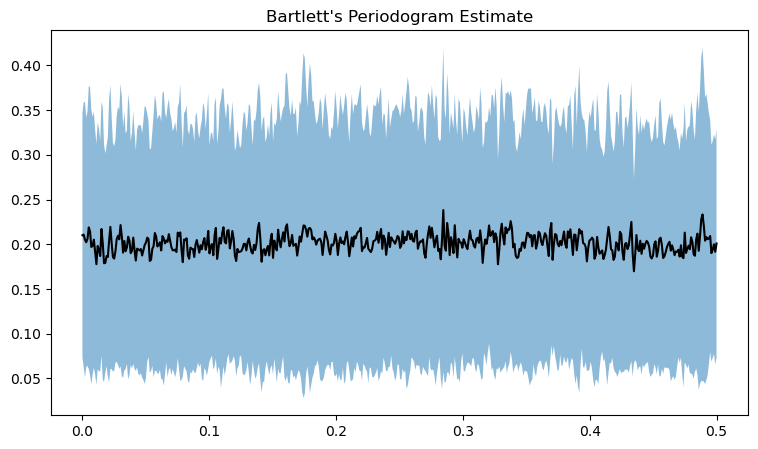

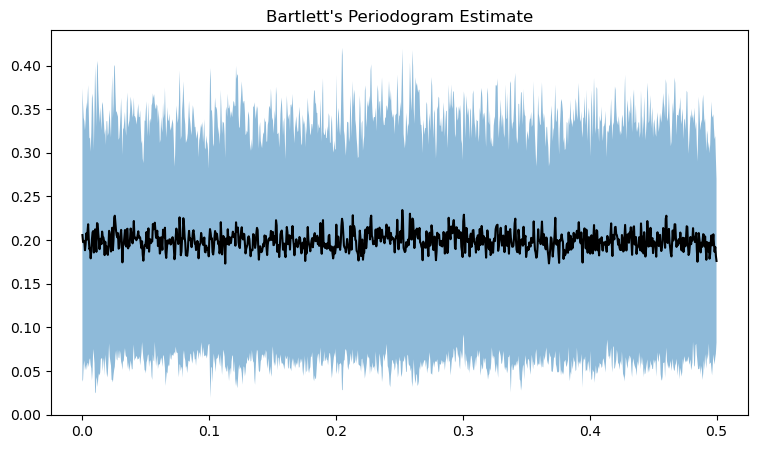

In [6]:
# Parameters to test
N_values = [200, 500, 1000]
K = 5  # Number of sections for Bartlett's method

for N in N_values:
    all_gamma_hats = np.zeros((100, N))
    all_periodograms = np.zeros((100, N), dtype=complex)

    for i in range(100):
        X = np.random.randn(N)  # Generate random data
        gamma_vals = gamma_hat(X, N)  # Compute the sample autocorrelation function
        periodogram_vals = bartlett_periodogram(X, N, K, f_s=1)  # Use Bartlett's estimate

        # Store the result
        all_gamma_hats[i, :] = gamma_vals
        all_periodograms[i, :] = periodogram_vals

    # Compute mean and standard deviation across simulations
    mean_gamma_hat = np.mean(all_gamma_hats, axis=0)
    std_gamma_hat = np.std(all_gamma_hats, axis=0)

    mean_periodogram = np.mean(all_periodograms, axis=0)
    std_periodogram = np.std(all_periodograms, axis=0)

    freqs = np.linspace(0, 0.5, N)
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.plot(freqs, mean_periodogram, 'k-')
    ax.fill_between(freqs, mean_periodogram - std_periodogram, mean_periodogram + std_periodogram, alpha=0.5)
    ax.set_title("Bartlett's Periodogram Estimate")
    plt.show()

# Dynamic time warping (DTW)

## Data

This data set consists of signals collected with inertial measurement units (accelerometer+gyroscope), from 230 subjects undergoing a fixed protocol:
- standing still,
- walking 10 m,
- turning around,
- walking back,
- stopping.

In this assignment, we only consider the vertical acceleration of the left foot and all signals are truncated to 20 seconds (as a result, they all have same length). Signals are sampled at 100 Hz.

The measured population is composed of healthy subjects as well as patients with neurological or orthopedic disorders.

The start and end time stamps of thousands of footsteps are available.

The data are part of a larger data set described in [1].

[1] Truong, C., Barrois-Müller, R., Moreau, T., Provost, C., Vienne-Jumeau, A., Moreau, A., Vidal, P.-P., Vayatis, N., Buffat, S., Yelnik, A., Ricard, D., & Oudre, L. (2019). A data set for the study of human locomotion with inertial measurements units. Image Processing On Line (IPOL), 9.

**The task** is to classify footsteps in healthy/non-healthy.

The following cell defines the training set `(X_train, y_train)` and testing set `(X_test, y_test)`.

In [7]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_train.append(signal[start:end])
        y_train.append(label)

        
X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = single_trial.signal.LAZ.to_numpy()  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology=="Healthy" else 1  # 0: healthy, 1: non-healthy
    for (start, end) in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

100%|██████████| 202M/202M [05:26<00:00, 617kiB/s]  


## Question 10

In [68]:
# We will use a library called dtai-distance to compute the DTW distance
from dtaidistance import dtw
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from tqdm import tqdm

# Function that select k nearest neighbors
def k_nearest_neighbors(X_train, y_train, X_test, k=5):
    y_pred = []
    for _, x_test in enumerate(X_test):
        distances = []
        for j, x_train in enumerate(X_train):
            distance = dtw.distance(x_test, x_train)
            distances.append([distance, y_train[j]])
        distances.sort(key=lambda x: x[0])
        k_nearest_class = [x[1] for x in distances[:k]]
        y_pred.append(max(set(k_nearest_class), key=k_nearest_class.count))
    return y_pred

# Cross-validation
for i in range(5):
    print("----------  Cross-validation ", i+1, " ----------")
    X_train_cross, X_val, y_train_cross, y_val = train_test_split(X_train, y_train, test_size=0.2)
    list_f1 = []
    for k in range(1, 9):
        y_pred = k_nearest_neighbors(X_train_cross, y_train_cross, X_val, k=k)
        f1 = f1_score(y_val, y_pred)
        print(f"F1 score for k={k}: {f1}")
        list_f1.append(f1)
    print("\n", "For the cross validation ", i+1, " the best k is ", np.argmax(list_f1)+1, " with a f1 score of ", np.max(list_f1), "\n")


----------  Cross-validation  1  ----------
F1 score for k=1: 0.8275862068965517
F1 score for k=2: 0.8148148148148148
F1 score for k=3: 0.8
F1 score for k=4: 0.7586206896551724
F1 score for k=5: 0.7586206896551724
F1 score for k=6: 0.7586206896551724
F1 score for k=7: 0.7586206896551724
F1 score for k=8: 0.7142857142857143

 For the cross validation  1  the best k is  1  with a f1 score of  0.8275862068965517 

----------  Cross-validation  2  ----------
F1 score for k=1: 0.875
F1 score for k=2: 0.8387096774193549
F1 score for k=3: 0.9090909090909091
F1 score for k=4: 0.9090909090909091
F1 score for k=5: 0.8823529411764706
F1 score for k=6: 0.8823529411764706
F1 score for k=7: 0.8823529411764706
F1 score for k=8: 0.8823529411764706

 For the cross validation  2  the best k is  3  with a f1 score of  0.9090909090909091 

----------  Cross-validation  3  ----------
F1 score for k=1: 0.8888888888888888
F1 score for k=2: 0.8125
F1 score for k=3: 0.8235294117647058
F1 score for k=4: 0.82352

In [85]:
# We have selected k=1 as the best value for k
k = 1
y_pred = k_nearest_neighbors(X_train, y_train, X_test, k=k)

f1 = f1_score(y_test, y_pred)
print(f"F1 score for k={k}: {f1}")

F1 score for k=1: 0.48214285714285715


## Question 11

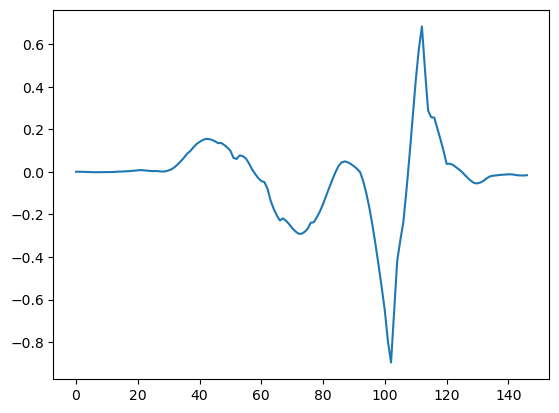

In [86]:
for i in range(len(X_test)):
    if y_pred[i] == 0 and y_test[i] == 1:
        plt.plot(X_test[i]) # Faux négatif
        break

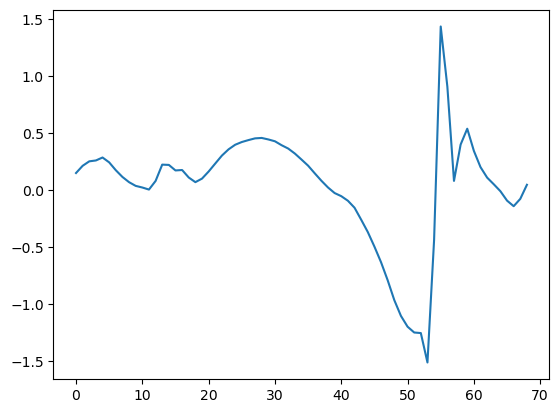

In [87]:
for i in range(len(X_test)):
    if y_pred[i] == 1 and y_test[i] == 0:
        plt.plot(X_test[i]) # Faux positif
        break